# Tutorial 1: the basics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geone
import geone.covModel as gcm
import os
import sys
import pyvista as pv

try:
    import ArchPy
except: # if ArchPy is not installed
    print("ArchPy not installed")
    sys.path.append("../..")
    import ArchPy

**How to make basic geological models with ArchPy**

**This notebook shows the most important features about ArchPy and its structure**

It all begins by creating a project with the Arch_table class. This class is inside the base submodule of ArchPy.

``
ArchPy.base.Arch_table(name, working_directory, seed, verbose, ncpu)
``


Arguments:

    - name will define a name for all files that this project will create and load.
    - The working_directory argument is the folder where to store ArchPy input/output files (folder must already exist).
    - seed is for reproducibility of the simulations
    - verbose can be 0 (few informations will be printed) or 1 (all informations will be printed)
    - ncpu : number of cpu to use, -1 for all minus 1. Note that ArchPy isn't parallelized and this parameter only influences some geone methods

## Step 0: Initialize model

In [2]:
T1 = ArchPy.base.Arch_table(name = "Super_project", working_directory="working_dir", seed = 100, verbose = 1)

**Once a project has been created, we can choose a simulation grid. This is done with the ``add_grid`` method by defining 3 parameters**

``dimensions`` which is a tuple containing the number of cells in x, y and z direction ``(nx, ny, nz)``

``spacing`` which is a tuple containing the cell width in x, y and z direction ``(sx, sy, sz)``

``origin`` which is a tuple containing the origin coordinates in x, y and z direction ``(ox, oy, oz)``

Note that others parameters can be passed such as a top, bot to define top and bottom of the simulation domain. Rasters can be passed directly. It is also possible to pass shapefiles for the delimitation of the domain. 

In [3]:
nx = 50 #number of cells in x
ny = 50 
nz = 50
sx = 1 #cell width in x
sy = 1
sz = 0.1
ox = 0 # x coordinates of the origin
oy = 0
oz = 0
dimensions = (nx, ny, nz)
spacing = (sx, sy, sz)
origin = (ox, oy, oz)

T1.add_grid(dimensions, spacing, origin) #adding the grid

## Adding Grid ##
## Grid added and is now simulation grid ##


## Step 1 : defining a Stratigraphic Pile

The first step is done by creating a Stratigraphic Pile that will contain the different units.
This can be done with ``ArchPy.base.Pile``.

Then this pile must be set as the Master pile of the project

In [4]:
P1 = ArchPy.base.Pile("Pile_1") # 

#The pile must be define as master pile of the project
T1.set_Pile_master(P1)

Pile sets as Pile master


## Step 2 : Units and Surfaces

This is done with the classes ``ArchPy.base.Unit`` and ``ArchPy.base.Surface``

For each unit, a surface must be defined. **This surface delimits the top of the unit**.

A surface is caracterized by :

- contact type (onlap or erode), which influences how it interacts with other surfaces
- Surface dictionnary (dic_surf) wich includes all parameters and method interpolations
    - int_method : interpolation method --> grf, grf_ineq, MPS, kriging, ...
    - covmodel : covariance model to use if int_method is grf, grf_ineq, kriging
    - mean : mean elevation for the unconditional simulation
        
A unit is caracterized by :

- A name
- an order that defines the unit position in the pile, ranging from 1 (youngest unit) to n (oldest unit).
- A surface object
- Unit dictionnary (dic_facies) which includes all the parameters and method for the filling of the unit.
    - f_method : filling method (SIS, MPS, homogenous, SubPile or TPGs)
    - f_covmodel : facies covmodels to use with the SIS
    - probability : facies proportions, in the same order than the facies passed to the Unit.
    - (see ArchPy documentation for all the parameters)

    
Here we will create **2** units which means that only oldest surface will be simulated, youngest will be set to top.
A surface is however required in order to create a unit object, even if it is useless.

Each surface will be filled with 2 lithofacies of different proportions using the SIS method.

Finally, the units are added to the Pile.

In [5]:
#Unit 1

#Creation of the top unit U1
covmodel_SIS = gcm.CovModel3D(elem = [("spherical", {"w":2, "r": [20,20,5]}),
                                      ("exponential", {"w":1, "r": [30,30,5]})])
dic_facies_u1 = {"f_method" : "SIS", #filling method
                 "f_covmodel" : covmodel_SIS, #SIS covmodels
                 "probability" : [0.2, 0.8] #facies proportions
                } #dictionnary for the unit filling

U1 = ArchPy.base.Unit(name = "U1",
                      order = 1,       #order in pile
                      color = "lightcoral",  
                      surface=ArchPy.base.Surface(),  # top surface
                      ID = 1,
                      dic_facies=dic_facies_u1
                     ) 



## Unit 2

#surface 2
covmodel_S2 = gcm.CovModel2D(elem = [("cubic", {"w":1, "r" : [25,35]})])
dic_surf_s2 = {"covmodel" : covmodel_S2, "int_method" : "grf_ineq", "mean" : 2.5}
S2 = ArchPy.base.Surface(name = "S1", dic_surf=dic_surf_s2)

#dic facies 2
dic_facies_u2 = {"f_method" : "SIS", "f_covmodel" : covmodel_SIS, "probability" : [0.3, 0.7]} #use same dic facies as u1

U2 = ArchPy.base.Unit(name = "U2",
                      order = 2,   #order in pile
                      color = "lime", #color
                      surface=S2, # top surface
                      ID = 2,     #ID
                      dic_facies=dic_facies_u2 #facies dictionnary
                     )


#Adding the units to the Pile
P1.add_unit([U1, U2])

Unit U1: covmodel for SIS added
Unit U1: Surface added for interpolation
Unit U2: covmodel for SIS added
Unit U2: Surface added for interpolation
Stratigraphic unit U1 added
Stratigraphic unit U2 added


## Step 3 : Facies

**It is know possible to defined some facies that will be added to the units**

two facies (Sand and Clay) will be added to U1 and two others (Gravel, Sandy gravel) to U2.

This can be done with ``ArchPy.base.Facies``.
A facies can then be passed to the unit with the ``add_facies`` method.
Warning, this method is an "adding" method it does not remove previously added facies. They should be remove manually wiht the following code : unit.list_facies = [].

**Warning : IDs must be different**

In [6]:
Sand = ArchPy.base.Facies(ID = 1, name = "Sand", color = "yellow")
Clay = ArchPy.base.Facies(ID = 2, name = "Clay", color = "royalblue")
Gravel = ArchPy.base.Facies(ID = 3, name = "Gravel", color = "palegreen")
Sandy_gravel = ArchPy.base.Facies(ID = 4, name = "Sandy_gravel", color = "darkorange")

U1.add_facies([Sand, Clay])
U2.add_facies([Gravel, Sandy_gravel])

Facies Sand added to unit U1
Facies Clay added to unit U1
Facies Gravel added to unit U2
Facies Sandy_gravel added to unit U2


## It is almost finished, last step :  Properties

Here we will create a property object with ``ArchPy.base.Prop``. 

Property objects are directly added to the project and not to the facies. 

Arguments are :
- name
- facies (the facies in which to simulate the prop)
- covmodels (covariance models for the simulation, one for each facies, same order of facies)
- means (mean values for the simulation, one for each facies)
- int_method (grf method --> SGS or FFT), SGS will probably be faster if a lot of units and facies are defined
- x  (position of the hard data, if any)
- v  (values of the hard data, if any)
- def_mean (default value to use if a facies have not been added to the "facies" arguments
- vmin, vmax (min and max values for the properties, simulated values below (resp. above) will be capped.

   
In this example one property is defined for the four facies, each with a different covariance models given in ``list_covmodels``, a list of 3D covmodels objects (see geone doc.). The order of the covmodels must be consistant with the order of the facies in ``list_facies``. The same applies for the ``means`` parameter.


Finally the property is added to the project with the method ``Arch_table.add_project``

In [7]:
#covmodels
cm_prop1 = gcm.CovModel3D(elem = [("spherical", {"w":0.1, "r":[10,10,10]}),
                                  ("cubic", {"w":0.1, "r":[15,15,15]})])
cm_prop2 = gcm.CovModel3D(elem = [("cubic", {"w":0.2, "r":[25, 25, 5]})])

list_facies = [Sand, Clay, Gravel, Sandy_gravel] #list of the facies to simulate
list_covmodels = [cm_prop2, cm_prop1, cm_prop2, cm_prop1] #list of 3D covariance models
means = [-4, -8, -3, -5] #mean property values
K = ArchPy.base.Prop("K", 
                     facies=list_facies,
                     covmodels=list_covmodels,
                     means=means,
                     int_method = "sgs",
                     vmin = -10,
                     vmax = -2
                    )

#adding the property to project
T1.add_prop(K)

Property K added


## Pre-processing

Now everything is set up, it is possible to pre-process the Hard Data. As there is none, this step can be skipped. 
A warning is printed indicating that no borehole have been found

In [8]:
T1.process_bhs()

##### ORDERING UNITS ##### 
Pile Pile_1: ordering units
Stratigraphic units have been sorted according to order
hierarchical relations set
No borehole found - no hd extracted


## Simulations

The three level of simulations can then be simulated with the following commands :

``compute_surf(nreal)``

``compute_facies(nreal)``

``compute_prop(nreal)``

In [9]:
T1.compute_surf(10)

Boreholes not processed, fully unconditional simulations will be tempted
########## PILE Pile_1 ##########
Pile Pile_1: ordering units
Stratigraphic units have been sorted according to order

#### COMPUTING SURFACE OF UNIT U2
U2: time elapsed for computing surface 0.003002643585205078 s

#### COMPUTING SURFACE OF UNIT U1
U1: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.0050048828125 s

#### COMPUTING SURFACE OF UNIT U2
U2: time elapsed for computing surface 0.0040035247802734375 s

#### COMPUTING SURFACE OF UNIT U1
U1: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.005004405975341797 s

#### COMPUTING SURFACE OF UNIT U2
U2: time elapsed for computing surface 0.0020017623901367188 s

#### COMPUTING SURFACE OF UNIT U1
U1: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.0050046443939208984 s

#### COMPUTING SURFACE OF UNIT U2
U2: time elapsed for computing surface 0.002001523971557617 s

#### COMPUT

In [10]:
T1.compute_facies(1)


### Unit U1: facies simulation with SIS method ####
### Unit U1 - realization 0 ###
Only one facies covmodels for multiples facies, adapt sill to right proportions
### Unit U1 - realization 1 ###
### Unit U1 - realization 2 ###
### Unit U1 - realization 3 ###
### Unit U1 - realization 4 ###
### Unit U1 - realization 5 ###
### Unit U1 - realization 6 ###
### Unit U1 - realization 7 ###
### Unit U1 - realization 8 ###
### Unit U1 - realization 9 ###
Time elapsed 4.8 s

### Unit U2: facies simulation with SIS method ####
### Unit U2 - realization 0 ###
Only one facies covmodels for multiples facies, adapt sill to right proportions
### Unit U2 - realization 1 ###
### Unit U2 - realization 2 ###
### Unit U2 - realization 3 ###
### Unit U2 - realization 4 ###
### Unit U2 - realization 5 ###
### Unit U2 - realization 6 ###
### Unit U2 - realization 7 ###
### Unit U2 - realization 8 ###
### Unit U2 - realization 9 ###
Time elapsed 4.84 s

### 9.65: Total time elapsed for computing facies ###


In [11]:
T1.compute_prop(1)

### 10 K property models will be modeled ###
### 1 K models done
### 2 K models done
### 3 K models done
### 4 K models done
### 5 K models done
### 6 K models done
### 7 K models done
### 8 K models done
### 9 K models done
### 10 K models done


## Retrieve results

Results can be retrieved with different functions of Arch_table : 
``.get_units_domains_realizations()``, ``.get_facies``, ``getprop(property)``


In [12]:
unit_domains = T1.get_units_domains_realizations().shape
facies_reals = T1.get_facies
K = T1.getprop("K")

## Plots

ArchPy offers multiple plotting functionnalities at different level such as : 

``plot_unit(iu)``, ``plot_facies(iu, ifa)``, ``plot_prop(property, iu, ifa, ip)``, ``plot_proba (object)``, ``plot_mean(property, type = arithmetic)``, etc.

Slice can always be drawn with the slicex, slicey and slicez arguments. slices are drawn at fraction of the x, y and z axis. For example, slicez = 0.3 indicates to draw a slice along xy plane and cutting z at 0.3 of zmax. 

here iu, ifa and ip are index for the different type of realizations made. iu = 1 for example indicating to plot the results related to the 2nd unit realization. Similarly, ifa and ip stand for the results associtated with the ifa facies and ip property realizations.

e.g ``T1.plot_prop("K", iu=5, ifa=1, ip=0)`` indicates to plot the 1st property realization made on the 2nd facies simulation itself realized on the 6th unit realization.

In [13]:
pv.set_jupyter_backend('static')

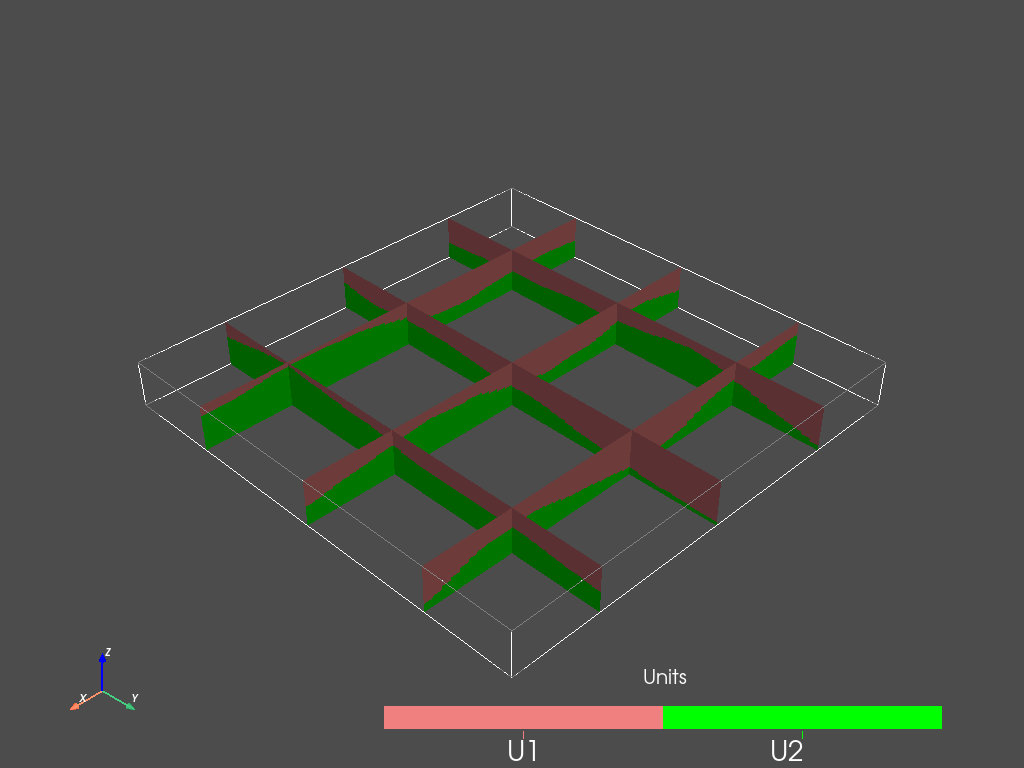

In [14]:
T1.plot_units(iu=0, slicex=(0.2, 0.5, 0.8), slicey=(0.2, 0.5, 0.8))

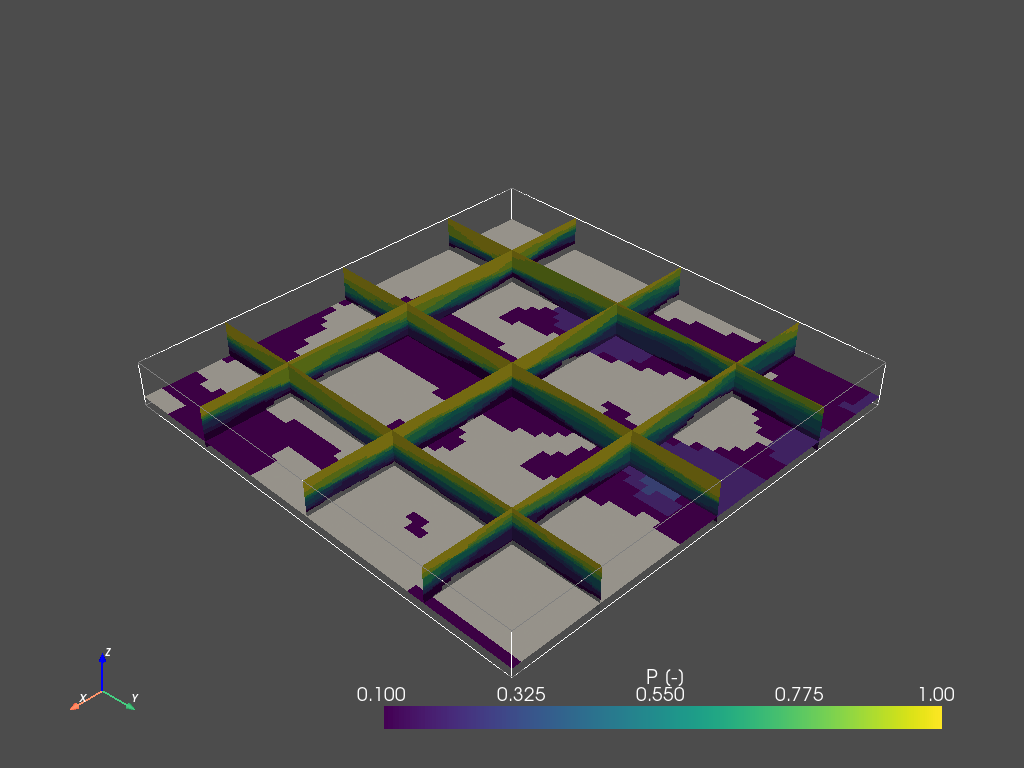

In [15]:
#plot probability of observing unit 1
T1.plot_proba("U1", slicex=(0.2, 0.5, 0.8), slicey=(0.2, 0.5, 0.8), slicez=0.2)

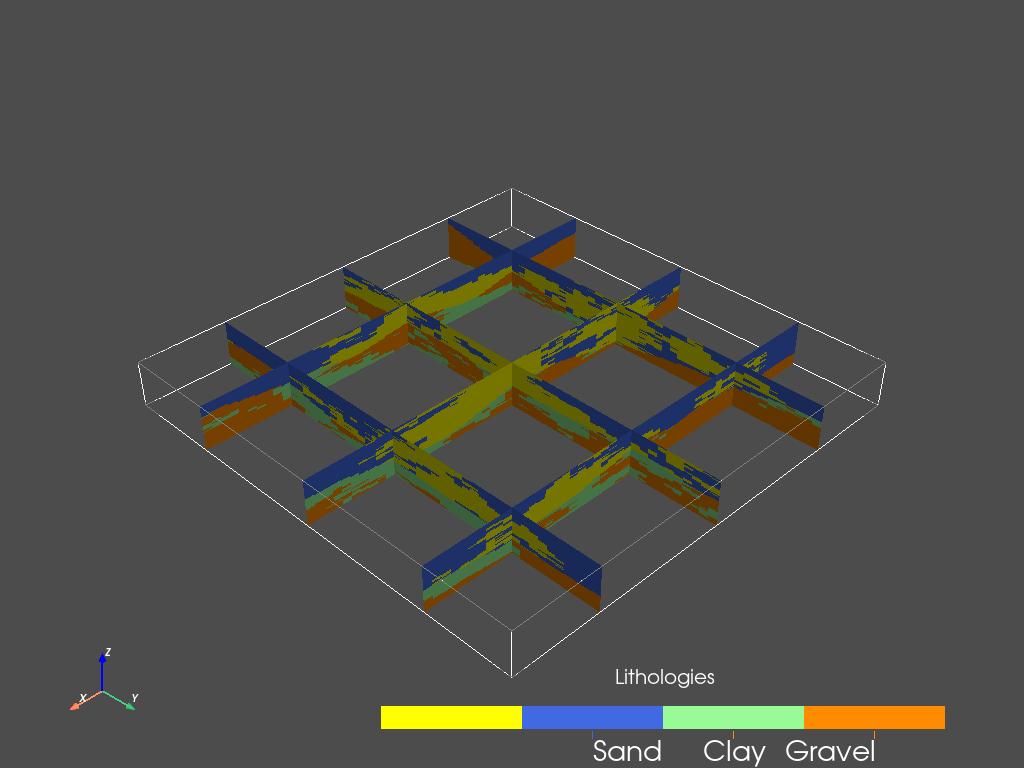

In [16]:
#plotting facies
T1.plot_facies(iu=1, ifa=0, slicex=(0.2, 0.5, 0.8), slicey=(0.2, 0.5, 0.8))

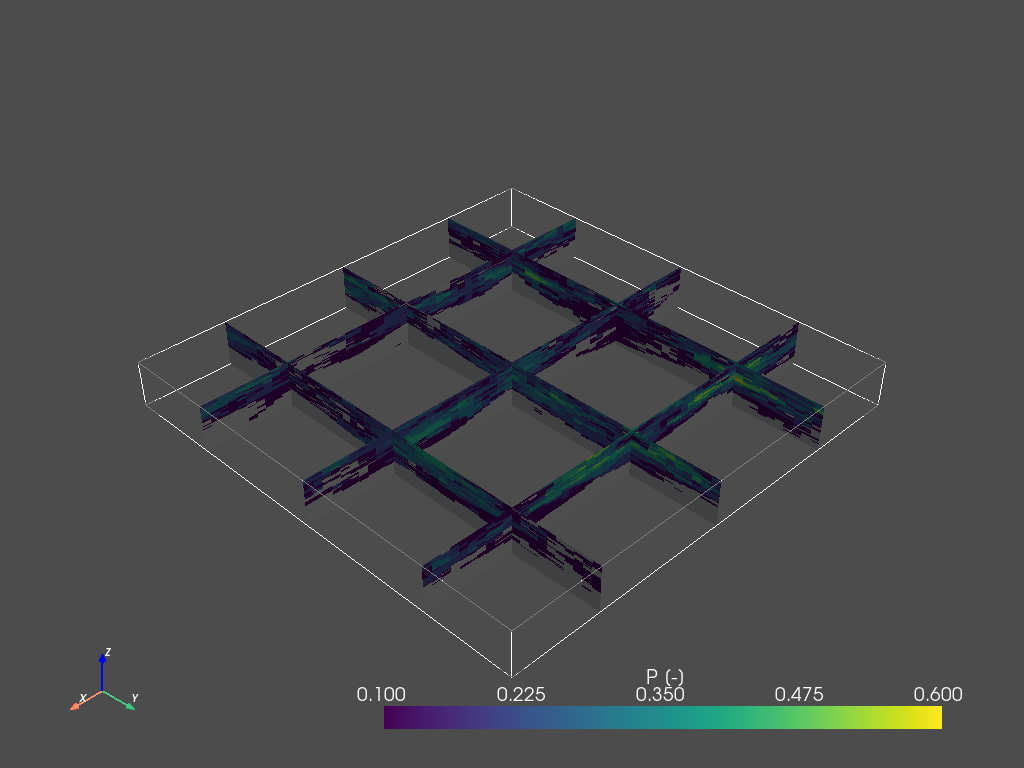

In [17]:
T1.plot_proba(Sand,slicex=(0.2, 0.5, 0.8), slicey=(0.2, 0.5, 0.8))

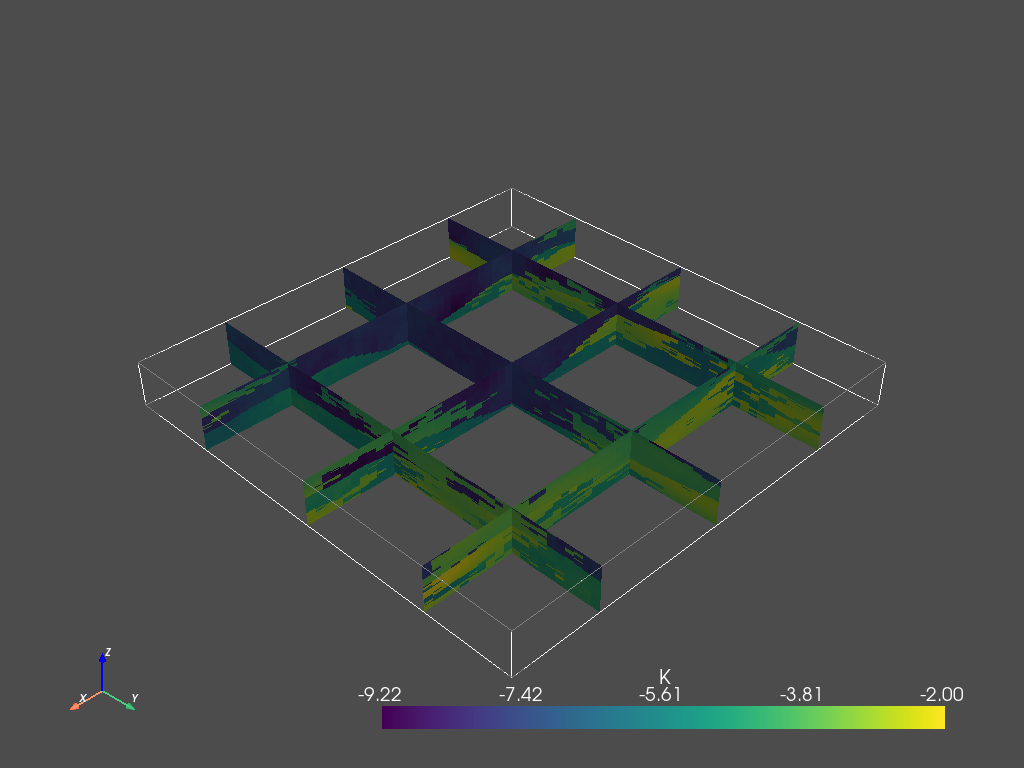

In [18]:
#plot prop
T1.plot_prop("K", iu=2, ifa=0, ip=0, slicex=(0.2, 0.5, 0.8), slicey=(0.2, 0.5, 0.8))

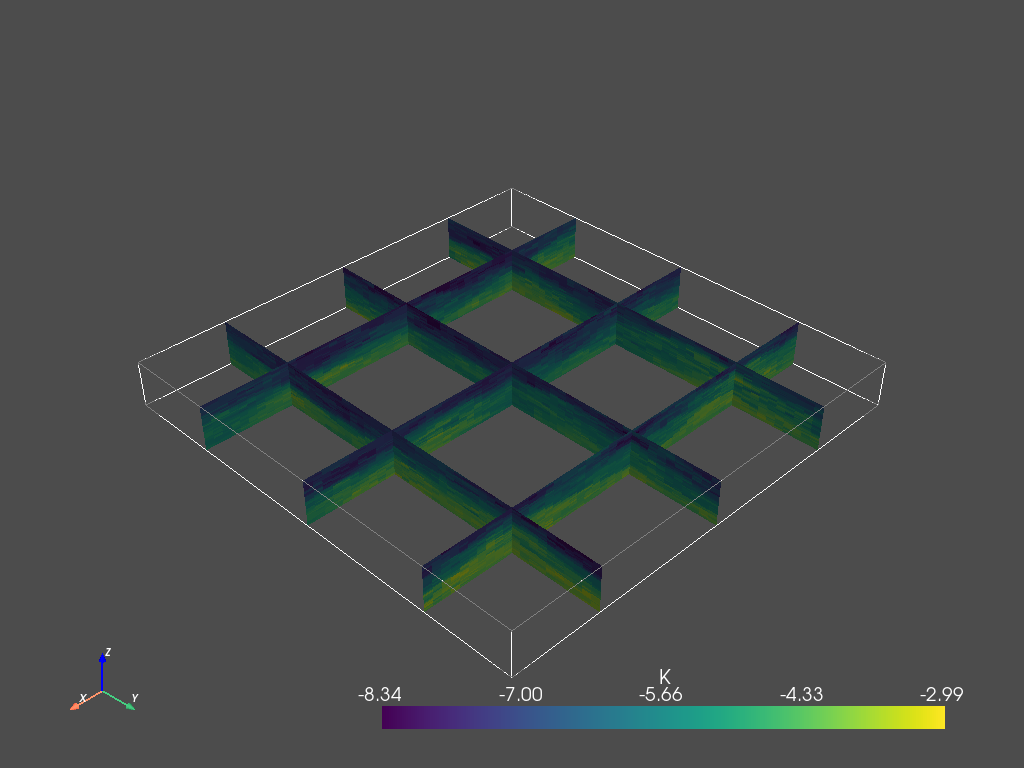

In [19]:
#mean prop value
T1.plot_mean_prop("K", type="arithmetic", slicex=(0.2, 0.5, 0.8), slicey=(0.2, 0.5, 0.8))

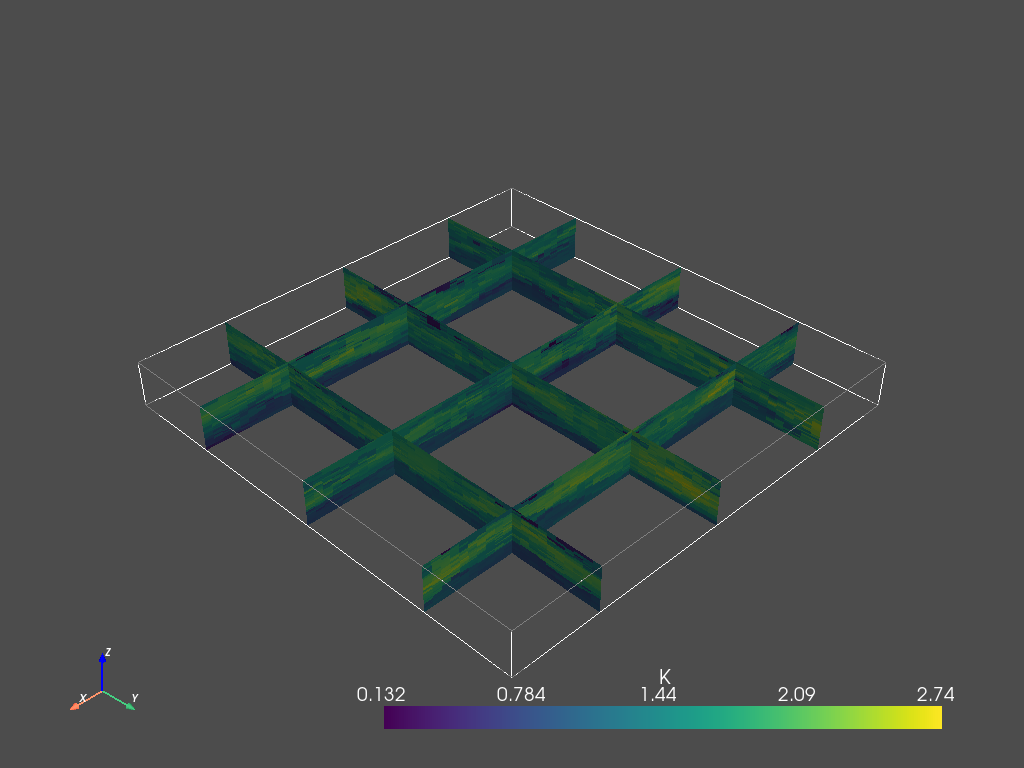

In [20]:
#Standard deviation
T1.plot_mean_prop("K", type="std",slicex=(0.2, 0.5, 0.8), slicey=(0.2, 0.5, 0.8))